<h1>AdaBoost Regression</h1>
<p>
    Model created using <a href="https://scikit-learn.org/stable/" target="_blank">scikit-learn.</a>
    <br/><br/>
    AdaBoost - Adaptive Boosting - is a subset of boosting models, boosting models springs from the idea of using multiple base prediction models (learners) to generate one stronger learner, the base learners are usually weak, however they could also be strong learners. AdaBoost is applicable to both classification and regression problems. In AdaBoost, subsequence learners that are generated after the first leraner is generated to cover the previous learner weakness. The most common type of AdaBoost uses simple decision trees models, offenly called stumps, as its base learner; this utilization of AdaBoost will also uses stumps as the base learners.
</p>

In [1]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as ma

%matplotlib inline

In [2]:
def get_csv(path: str) -> pd.DataFrame:

    return pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price', '24h High (USD)': 'high', '24h Low (USD)': 'low'})


def transform_df(df: pd.DataFrame) -> pd.DataFrame:

    transformed_df = pd.DataFrame(columns = ['date', 'price', 'previous price', 'previous high', 'previous low'])

    for i in range(1, df.shape[0]):
        transformed_df.loc[i - 1] = {'date': df.loc[i]['date'], 'price': df.loc[i]['price'], 'previous price': df.loc[i - 1]['price'], 'previous high': df.loc[i - 1]['high'], 'previous low': df.loc[i - 1]['low']}

    return transformed_df

    
def MAPE(pred, real) -> float:
    return np.mean(abs(1 - (pred / real)))


def RMSE(pred, real) -> float:
    return np.sqrt(np.mean((real - pred) ** 2))
    

def MSE(pred, real) -> float:
    return np.mean((real - pred) ** 2)


def plot_graph(*args, title: str = None, colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], **kwargs) -> None:

    plt.figure(figsize = (20, 6))
    number_of_graph = 0
    
    if title is not None:
        plt.title(title)

    for arg in args:
        plt.plot(arg, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    for kw in kwargs:
        plt.plot(kwargs[kw], label = kw, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    if len(kwargs) > 0:
        plt.legend(loc = 'best')

    plt.show()

<h3>Transforming Data</h3>
<p>
    AdaBoost models face the same problem with knn models when it comes to predicting stock and crypto prices: there is no information about tomorrow's prices. So the solution is to use today's data instead of tomorrow's.
</p>

In [3]:
df_ada = transform_df(get_csv('./data/cardano.csv'))
df_ada.head()

,date,price,previous price,previous high,previous low
0,2021-04-03,1.190702,1.183859,1.199795,1.172410
1,2021-04-04,1.163845,1.190702,1.243297,1.181267
2,2021-04-05,1.181918,1.163845,1.239910,1.160860
3,2021-04-06,1.211882,1.181918,1.193175,1.153233
4,2021-04-07,1.253378,1.211882,1.225536,1.163506


<p>
    Spliting data for training and testing.
</p>

In [4]:
train_x_ada = df_ada[['previous price', 'previous high', 'previous low']][:ma.floor(df_ada.shape[0] * 0.7)].to_numpy()
train_y_ada = df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)]
test_x_ada  = df_ada[['previous price', 'previous high', 'previous low']][ma.floor(df_ada.shape[0] * 0.7):].to_numpy()
test_y_ada  = df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]

---

<h3>Creating the Model</h3>
<p>
    For this AdaBoost, the model will be in its default from: using 50 Decision tree regressors as the base models.
</p>

In [5]:
model_ada = AdaBoostRegressor().fit(train_x_ada, train_y_ada)
pred_ada = pd.Series(model_ada.predict(test_x_ada), index = test_y_ada.index)

In [6]:
MAPE(pred_ada, test_y_ada) * 100

4.79407632460398

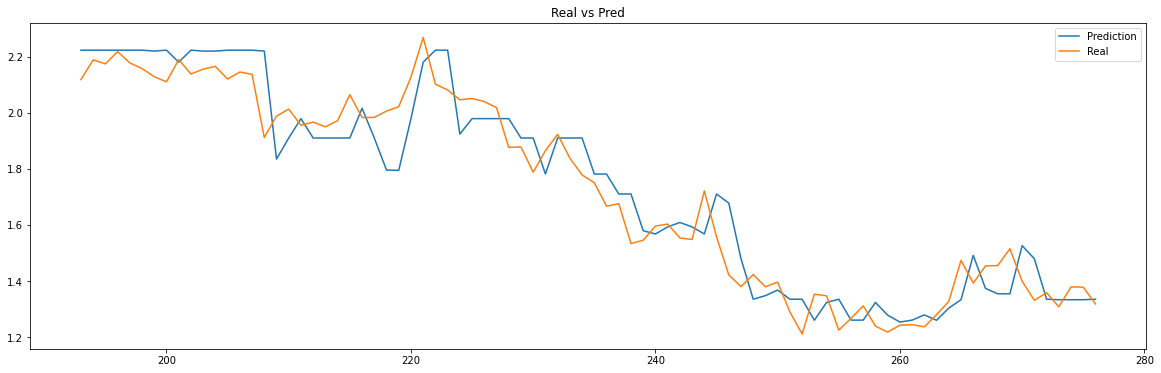

In [7]:
plot_graph(title = 'Real vs Pred', Prediction = pred_ada, Real = test_y_ada)

---

<h3>Finding the Otimal Number of Base Models</h3>
<p>
    Generally, using more base models will lead to better model, however using too much base models and the final model be complicated, not only that, it might also run into the problem of overfitting: model can predict data it was trained with well, but failed to predict new data. On the other hand, if the model have to little base models underfitting can occur: the model is bad at predicting everything. To negate both the model nees to strike a balance between too much and too little.
    <br/><br/>
    To roughly find the otimal number of base models, we can compare models with different number of base models with eachother.
    <br/>
    To make life easier, the function below will build models with different number of base models and return their MAPE (Mean absolute percentage error).
</p>

In [8]:
def n_estimators_test(df: pd.DataFrame, max_depth: int = 3, max_estimators: int = 100, test_ratio: float = 0.3) -> pd.Series:
    result = pd.Series(dtype = np.float64)

    for n_estimators in range(1, max_estimators + 1):
        train_x = df[['previous price', 'previous high', 'previous low']][:ma.floor(df.shape[0] * (1 - test_ratio))].to_numpy()
        train_y = df['price'][:ma.floor(df.shape[0] * (1 - test_ratio))]
        test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):].to_numpy()
        test_y = df['price'][ma.floor(df.shape[0] * (1 - test_ratio)):]

        model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators)
        model.fit(train_x, train_y)
        pred = model.predict(test_x)
        mape = MAPE(pred, test_y)
        result.loc[n_estimators] = mape

    return result

In [9]:
n_estimators_ada = n_estimators_test(df_ada, max_depth = 4)

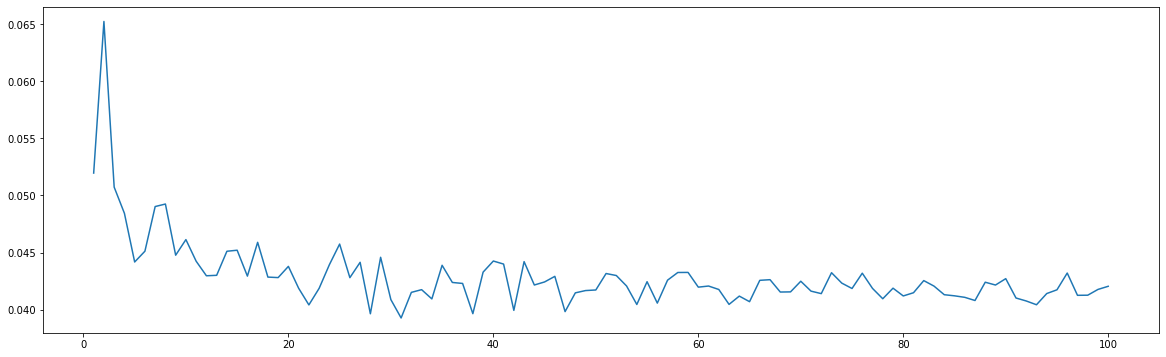

In [10]:
plot_graph(n_estimators_ada)

In [11]:
n_estimators_ada.sort_values().head()

31    0.039283
28    0.039651
38    0.039659
47    0.039840
42    0.039949
dtype: float64

<p>
    It would seems like that the AdaBoost Regressor should have around 40 base models.
</p>

In [12]:
model_ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 4), n_estimators = 40).fit(train_x_ada, train_y_ada)
pred_ada = pd.Series(model_ada.predict(test_x_ada), index = test_y_ada.index)

In [13]:
MAPE(pred_ada, test_y_ada) * 100

4.1063567923108435

In [14]:
RMSE(pred_ada, test_y_ada)

0.08605537905939331

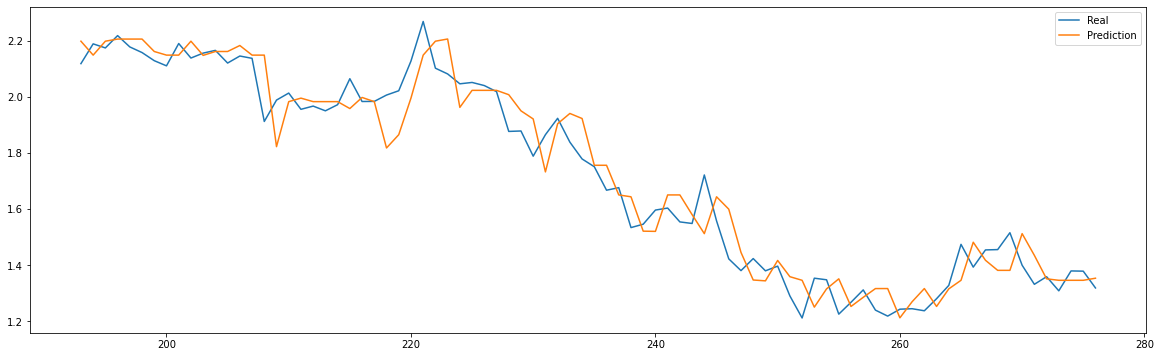

In [15]:
plot_graph(Real = test_y_ada, Prediction = pred_ada)

---

<h3>Rolling Forecast</h3>
<p>
    So now that the model is created with the otimal number of base models, with the accuracy hovering around 4.31% (since the RMSE changes for every new models), but the model could do better, lets try applying rolling forecast to AdaBoost and see how it goes.
</p>

In [16]:
def rolling_adaboost(df: pd.DataFrame, max_depth: int = 3, n_estimators: int = 50, test_ratio: float = 0.3) -> pd.DataFrame:
    
    test_x = df[['previous price', 'previous high', 'previous low']][ma.floor(df.shape[0] * (1 - test_ratio)):]
    test_y = df['price'][ma.floor(df.shape[0] * (1 - test_ratio)):]
    pred = pd.DataFrame(columns = ['pred', 'real'], dtype = np.float64)
    model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = max_depth), n_estimators = n_estimators)

    for i in test_y.index:
        train_x = df[['previous price', 'previous high', 'previous low']][:i].to_numpy()
        train_y = df['price'][:i]
        model.fit(train_x, train_y)
        pred.loc[i] ={'pred': model.predict([test_x.loc[i].to_numpy()])[0], 'real': test_y.loc[i]}
        
    return pred

In [17]:
rolling_ada = rolling_adaboost(df_ada, 4, 49)

4.068351965679289 %
0.08526450220772804


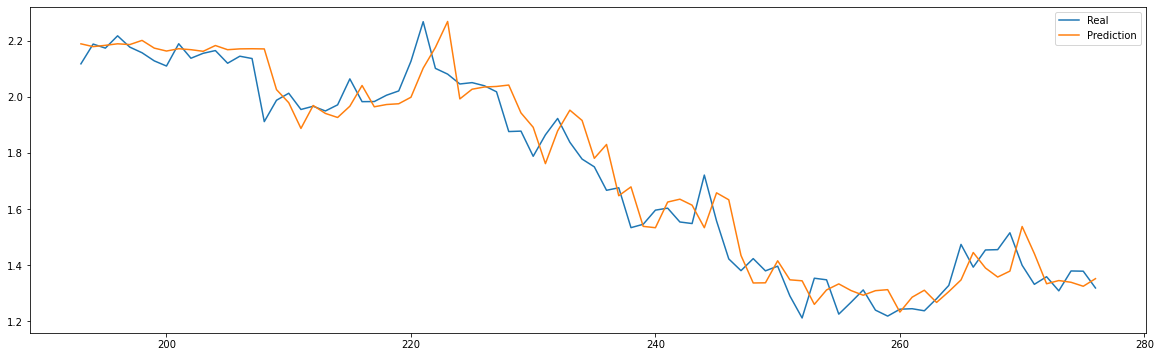

In [18]:
print(MAPE(rolling_ada['pred'], rolling_ada['real']) * 100, '%')
print(RMSE(rolling_ada['pred'], rolling_ada['real']))
plot_graph(Real = rolling_ada['real'], Prediction = rolling_ada['pred'])

<p>
    Well, the preformance improved, but not by a large margin: it's now around 4%.
</p>

---

<h3>ETH</h3>

In [19]:
df_eth = transform_df(get_csv('./data/ethereum.csv'))

In [20]:
n_estimators_eth = n_estimators_test(df_eth, test_ratio = 0.1)
n_estimators_eth.sort_values().head()

87    0.059668
95    0.061024
94    0.061468
79    0.062556
53    0.062624
dtype: float64

In [21]:
rolling_eth = rolling_adaboost(df_eth, n_estimators = 60)

5.7012551056796115 %
172.10367431483766


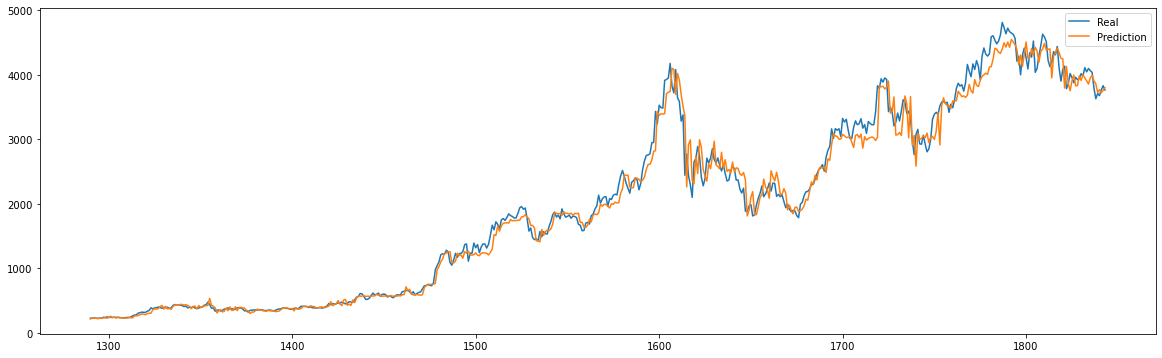

In [22]:
print(MAPE(rolling_eth['pred'], rolling_eth['real']) * 100, '%')
print(RMSE(rolling_eth['pred'], rolling_eth['real']))
plot_graph(Real = rolling_eth['real'], Prediction = rolling_eth['pred'])

---

<h3>DOGE</h3>

In [23]:
df_doge = transform_df(get_csv('./data/dogecoin.csv'))[770:]

In [24]:
n_estimators_test(df_doge).sort_values().head()

13    0.107017
18    0.111995
66    0.115968
43    0.116058
39    0.117135
dtype: float64

In [25]:
rolling_doge = rolling_adaboost(df_doge, n_estimators = 60)

8.96 %
0.024022651235505937


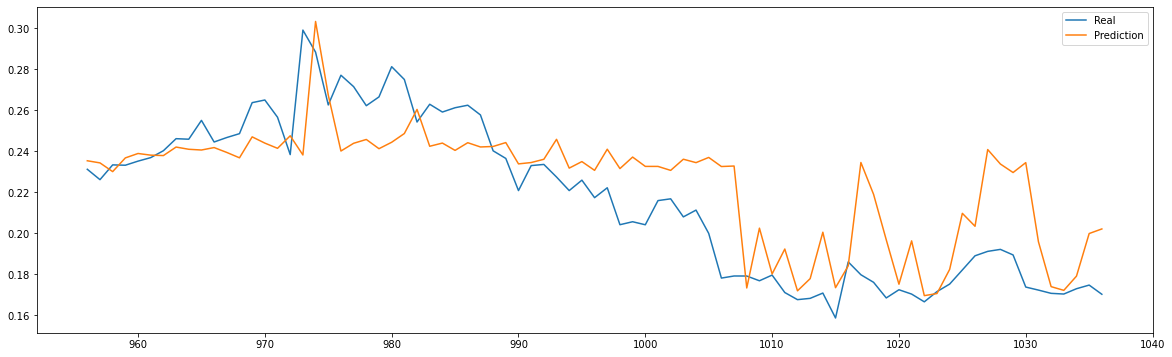

In [26]:
print(np.round(MAPE(rolling_doge['pred'], rolling_doge['real']) * 100, 2), '%')
print(RMSE(rolling_doge['pred'], rolling_doge['real']))
plot_graph(Real = rolling_doge['real'], Prediction = rolling_doge['pred'])

---

<h3>SOL</h3>

In [27]:
df_sol = transform_df(get_csv('./data/solana.csv'))

In [28]:
n_estimators_test(df_sol).sort_values().head()

1     0.068599
83    0.070667
44    0.070971
73    0.071544
79    0.071872
dtype: float64

In [29]:
pred_sol = rolling_adaboost(df_sol, n_estimators = 75)

4.61 %
10.562139652383998


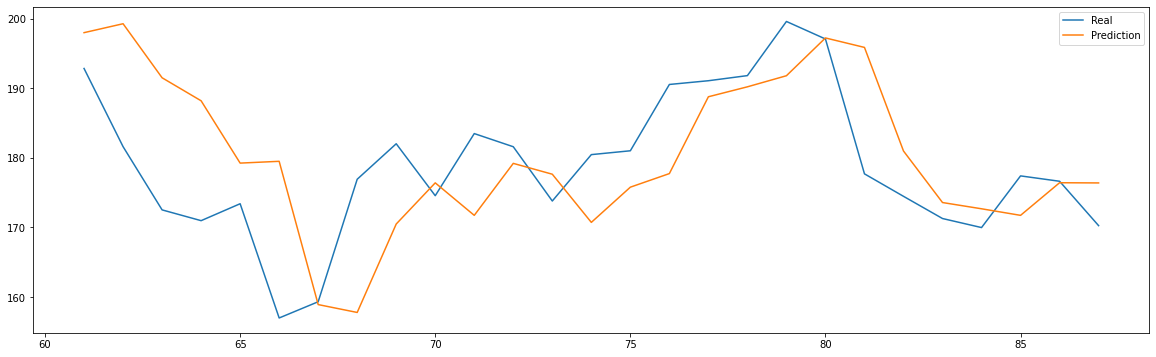

In [30]:
print(np.round(MAPE(pred_sol['pred'], pred_sol['real']) * 100, 2), '%')
print(RMSE(pred_sol['pred'], pred_sol['real']))
plot_graph(Real = pred_sol['real'], Prediction = pred_sol['pred'])